#INFO6152 - Training CNNs on Handwritten Digit Recognition (MNIST)

##1. Importing Libraries

In [11]:
# Importing Necessary Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

##2. Dataset Loading

In [12]:
# Setting random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Loading and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalizing pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshaping data to include channel dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Converting labels to categorical
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test_categorical.shape}")

Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)


##3. Data Prepeparation / Augmentation

Final training data: (48000, 28, 28, 1)
Validation data: (12000, 28, 28, 1)
Visualizing data augmentation


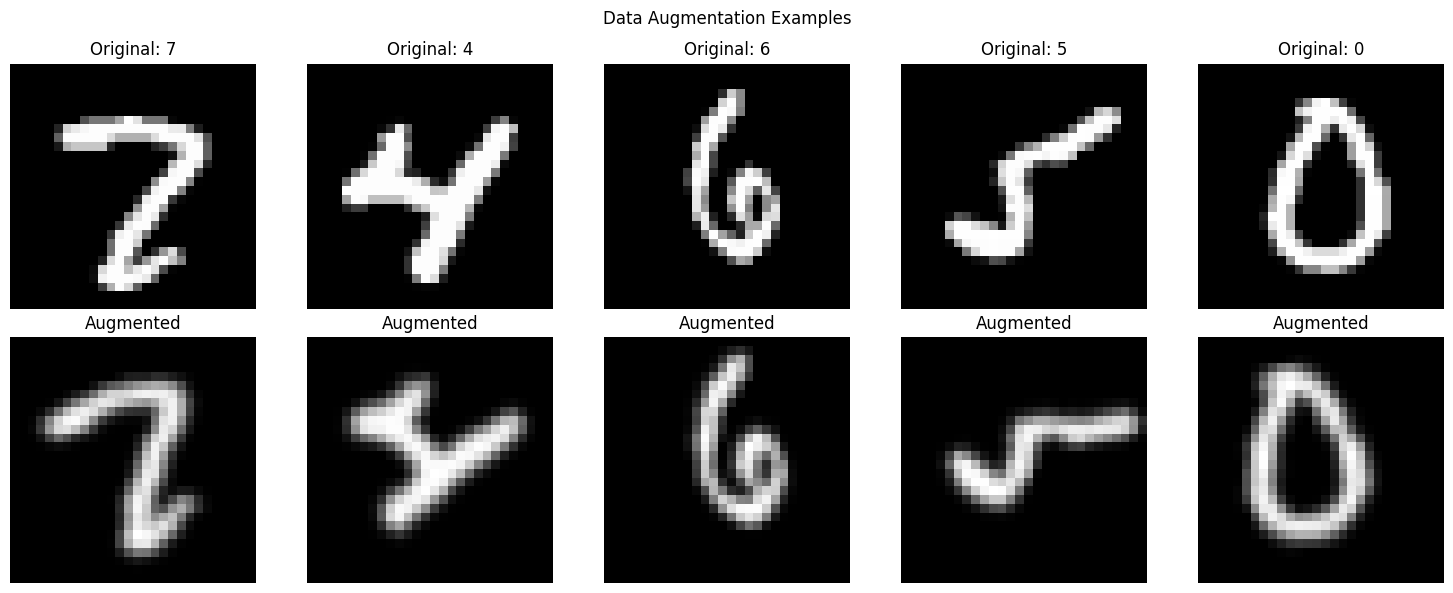

In [13]:
# Splitting training data into training and validation sets
val_split = 0.2
val_size = int(len(x_train) * val_split)

x_val = x_train[:val_size]
y_val = y_train_categorical[:val_size]
x_train_final = x_train[val_size:]
y_train_final = y_train_categorical[val_size:]

print(f"Final training data: {x_train_final.shape}")
print(f"Validation data: {x_val.shape}")

# Defining data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),  # Rotate by +-10%
    layers.RandomZoom(0.1),      # Zoom by +-10%
    layers.RandomTranslation(0.1, 0.1),  # Shift by +-10%
])

# Visualizing augmented images
def visualize_augmentation(images, labels, augmentation, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original: {np.argmax(labels[i])}')
        axes[0, i].axis('off')

        # Augmented image
        augmented = augmentation(tf.expand_dims(images[i], 0))
        axes[1, i].imshow(augmented[0].numpy().squeeze(), cmap='gray')
        axes[1, i].set_title('Augmented')
        axes[1, i].axis('off')

    plt.suptitle('Data Augmentation Examples')
    plt.tight_layout()
    plt.show()

# Showing augmentation examples
print("Visualizing data augmentation")
visualize_augmentation(x_train_final[:5], y_train_final[:5], data_augmentation)

##4. Defining the CNN model

In [14]:
# Defining the CNN model architecture
def create_cnn_model():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Classification block
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

# Creating both models
model_no_aug = create_cnn_model()
model_with_aug = create_cnn_model()

# Compiling both models with same settings
model_no_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_with_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model 1 (No Augmentation) Summary:")
model_no_aug.summary()

print("\nModel 2 (With Augmentation) Summary:")
model_with_aug.summary()

Model 1 (No Augmentation) Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Model 2 (With Augmentation) Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

The chosen Convolutional Neural Network architecture is a balanced and effective design for the MNIST digit classification task. It starts with two convolutional blocks, each pairing a convolutional layer with a max-pooling layer. The first block uses 32 filters to learn basic features like edges and curves, while the second uses 64 filters to combine these into more complex shapes. This progressive structure, increasing feature complexity while reducing spatial size, is a core strength of CNNs. Following these blocks, the network flattens the features and uses a dense layer with 128 neurons to perform the final classification. A key addition is a dropout layer, which randomly turns off neurons during training to prevent the model from overfitting and forces it to learn more robust patterns. The final output layer uses a softmax activation to assign a probability to each of the 10 digit classes. In essence, this model is powerful enough to capture the complexities of handwritten digits but streamlined enough to train efficiently and generalize well to new, unseen data.

##5. Trainning Model

Training Model 1 (No Augmentation)
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.7750 - loss: 0.6969 - val_accuracy: 0.9750 - val_loss: 0.0843
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9647 - loss: 0.1218 - val_accuracy: 0.9829 - val_loss: 0.0593
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.9746 - loss: 0.0851 - val_accuracy: 0.9862 - val_loss: 0.0499
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.9787 - loss: 0.0683 - val_accuracy: 0.9872 - val_loss: 0.0445
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.9836 - loss: 0.0555 - val_accuracy: 0.9879 - val_loss: 0.0432
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9860 - loss: 0.0510 - val_accuracy: 0.9885 - val_loss: 0.0402
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.9872 - loss: 0.0399 - val_accuracy: 0.9901 - val_loss: 0.0362
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step -

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.6427 - loss: 1.0699 - val_accuracy: 0.9700 - val_loss: 0.0974
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9143 - loss: 0.2768 - val_accuracy: 0.9784 - val_loss: 0.0715
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9416 - loss: 0.1963 - val_accuracy: 0.9822 - val_loss: 0.0573
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9536 - loss: 0.1576 - val_accuracy: 0.9854 - val_loss: 0.0501
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9568 - loss: 0.1417 - val_accuracy: 0.9848 - val_loss: 0.0508
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9657 - loss: 0.1168 - val_accuracy: 0.9862 - val_loss: 0.0442
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9665 - loss: 0.1125 - val_accuracy: 0.9871 - val_loss: 0.0417
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9690 - loss: 0.1052 - val_accurac

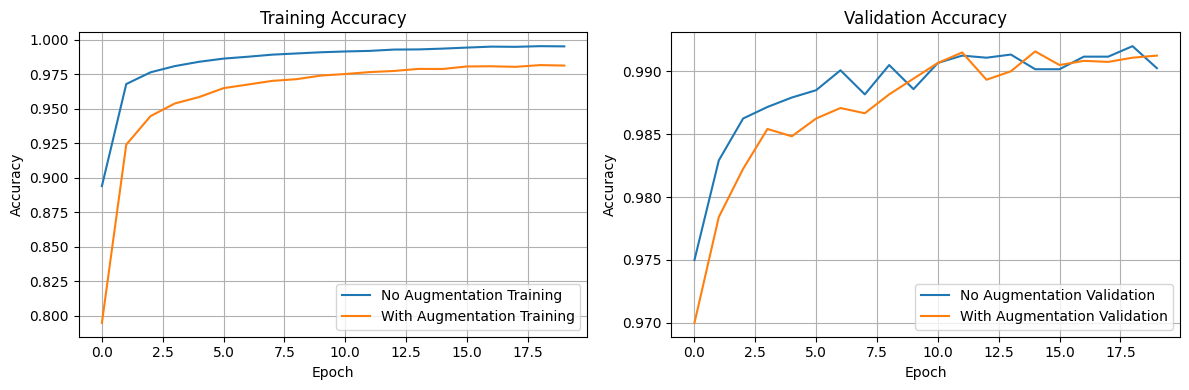

Plotting loss comparison:


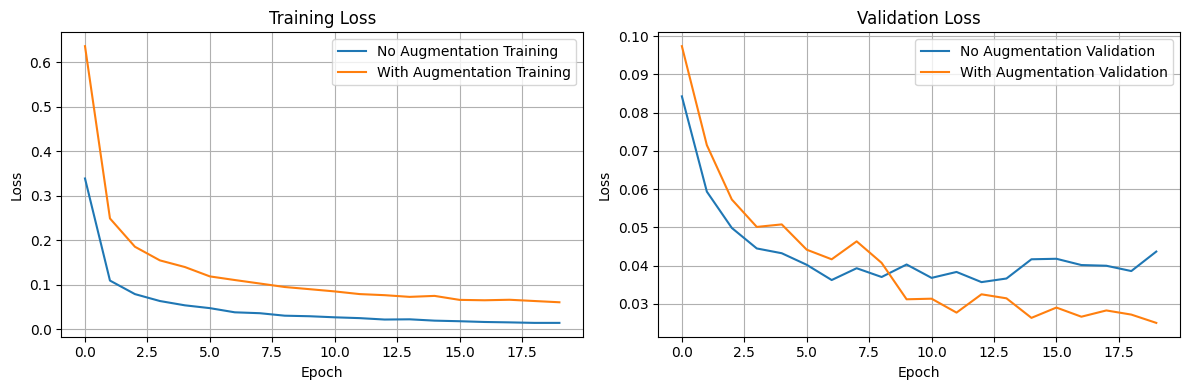

In [15]:
# Training parameters
epochs = 20
batch_size = 128

# Train Model 1 (No Augmentation)
print("Training Model 1 (No Augmentation)")
start_time_no_aug = time.time()

history_no_aug = model_no_aug.fit(
    x_train_final, y_train_final,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1
)

training_time_no_aug = time.time() - start_time_no_aug
print(f"Model 1 training time: {training_time_no_aug:.2f} seconds")

# Train Model 2 (With Augmentation)
print("\nTraining Model 2 (With Augmentation)")
start_time_with_aug = time.time()

# Create data generator with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow(
    x_train_final, y_train_final,
    batch_size=batch_size
)

history_with_aug = model_with_aug.fit(
    train_generator,
    steps_per_epoch=len(x_train_final) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1
)

training_time_with_aug = time.time() - start_time_with_aug
print(f"Model 2 training time: {training_time_with_aug:.2f} seconds")

# Plotting function
def plot_comparison(history1, history2, label1, label2, metric):
    plt.figure(figsize=(12, 4))

    # Training metric
    plt.subplot(1, 2, 1)
    plt.plot(history1.history[metric], label=f'{label1} Training')
    plt.plot(history2.history[metric], label=f'{label2} Training')
    plt.title(f'Training {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    # Validation metric
    plt.subplot(1, 2, 2)
    plt.plot(history1.history[f'val_{metric}'], label=f'{label1} Validation')
    plt.plot(history2.history[f'val_{metric}'], label=f'{label2} Validation')
    plt.title(f'Validation {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot accuracy comparison
print("Plotting accuracy comparison:")
plot_comparison(history_no_aug, history_with_aug,
                'No Augmentation', 'With Augmentation', 'accuracy')

# Plot loss comparison
print("Plotting loss comparison:")
plot_comparison(history_no_aug, history_with_aug,
                'No Augmentation', 'With Augmentation', 'loss')

Based on the training performance of the two models, several important trends become evident and prove the intrinsic influence of data augmentation on the process of learning. The model that was not augmented experienced extremely fast initial convergence with 77.5% accuracy in the first epoch and rapidly increasing to 96.5% by the second epoch. This speedy learning evolution was sustained in the course of training, with a final training accuracy of 99.5% and an equally small training loss of 0.015. However, this outstanding training performance came at the expense of suggestions of probable overfitting, since validation accuracy plateaued at 99.0-99.2% but training accuracy continued to rise, creating a huge difference in training versus validation performance.

On the other hand, the model trained on the data augmentation began with significantly more hardship, beginning at just 64.3% accuracy in epoch one with a huge loss of 1.07. The bumpy start is due to the increased complexity of the added data, where the model must contend with rotated, shifted, and zoomed variations of digits that make early pattern recognition more difficult. The training process was slower and more linear, with the model reaching comparable validation accuracy to the non-augmented model at later epochs but much lower training accuracy at 98.2%.

The strongest comparison is within the relationship between training and validation measures. While the non-augmented model achieved nearly optimal training performance, the augmented model exhibited higher consistency between its training and validation performance with only a 0.3% difference compared to the 0.5% gap in the non-augmented model. This higher consistency is a sign of higher generalization ability. Moreover, the curve of validation loss shows a remarkable advantage of the augmented model with an end validation loss of 0.025 compared to 0.0437 for the non-augmented model, suggesting more robust and confident predictions on new data.

The difference in computational cost, with augmentation taking approximately 36 seconds of extra training time, is the cost of computation of processing the dynamically created variations. But this extra cost bought worthwhile dividends in model regularization and generalization. The learning curve of the bigger model, while slower at first, was more stable and consistent without the uncontrolled early bounds that habitually characterize models memorizing training data. This more consistent adjective learning path, and the better training-validation alignment and lower final validation loss, both indicate that data augmentation actually served its function as a regularizer, forcing the model to learn more fundamental features of digit recognition rather than memorizing some specific instances of the training set.

##6. Evaluation Metrics

Evaluating models on test set
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

TEST RESULTS COMPARISON

Model 1 (No Augmentation):
Test Loss: 0.0288
Test Accuracy: 0.9926

Model 2 (With Augmentation):
Test Loss: 0.0186
Test Accuracy: 0.9941

Training Time Comparison:
Model 1 (No Augmentation): 662.83 seconds
Model 2 (With Augmentation): 699.18 seconds
Time Difference: 36.36 seconds

DETAILED CLASSIFICATION REPORT - MODEL 1 (No Augmentation)
              precision    recall  f1-score   support

           0     0.9919    0.9959    0.9939       980
           1     0.9930    0.9991    0.9960      1135
           2     0.9932    0.9913    0.9922      1032
           3     0.9941    0.9931    0.9936      1010
           4     0.9909    0.9969    0.9939       982
           5     0.9888    0.9899    0.9894       892
           6     0.9948    0.9916    0.9932       958
           7     0.9884    0.9932    0.9908      1028
           8     0.9948    0.9897 

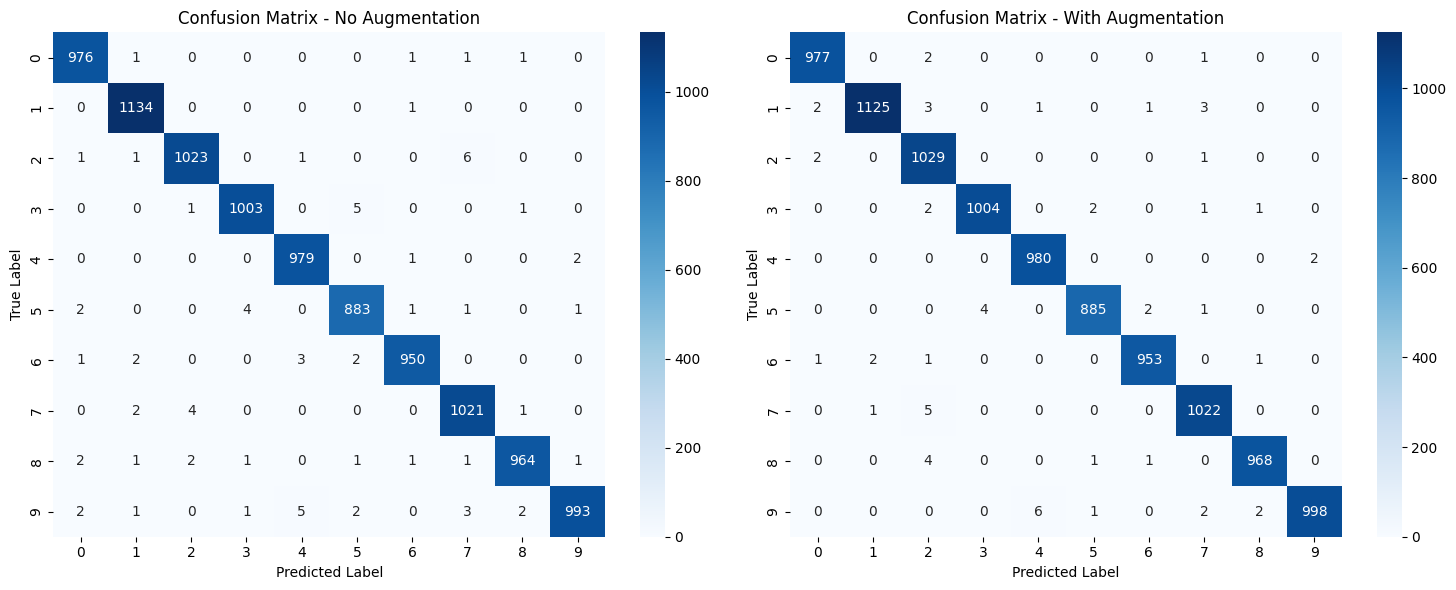

In [16]:
# Evaluate models on test set
print("Evaluating models on test set")

# Model 1 evaluation
test_loss_no_aug, test_accuracy_no_aug = model_no_aug.evaluate(x_test, y_test_categorical, verbose=0)
y_pred_no_aug = model_no_aug.predict(x_test)
y_pred_classes_no_aug = np.argmax(y_pred_no_aug, axis=1)

# Model 2 evaluation
test_loss_with_aug, test_accuracy_with_aug = model_with_aug.evaluate(x_test, y_test_categorical, verbose=0)
y_pred_with_aug = model_with_aug.predict(x_test)
y_pred_classes_with_aug = np.argmax(y_pred_with_aug, axis=1)

# Print test results
print("\n" + "="*60)
print("TEST RESULTS COMPARISON")
print("="*60)

print(f"\nModel 1 (No Augmentation):")
print(f"Test Loss: {test_loss_no_aug:.4f}")
print(f"Test Accuracy: {test_accuracy_no_aug:.4f}")

print(f"\nModel 2 (With Augmentation):")
print(f"Test Loss: {test_loss_with_aug:.4f}")
print(f"Test Accuracy: {test_accuracy_with_aug:.4f}")

print(f"\nTraining Time Comparison:")
print(f"Model 1 (No Augmentation): {training_time_no_aug:.2f} seconds")
print(f"Model 2 (With Augmentation): {training_time_with_aug:.2f} seconds")
print(f"Time Difference: {training_time_with_aug - training_time_no_aug:.2f} seconds")

# Detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - MODEL 1 (No Augmentation)")
print("="*60)
print(classification_report(y_test, y_pred_classes_no_aug, digits=4))

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - MODEL 2 (With Augmentation)")
print("="*60)
print(classification_report(y_test, y_pred_classes_with_aug, digits=4))

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Model 1 confusion matrix
cm1 = confusion_matrix(y_test, y_pred_classes_no_aug)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix - No Augmentation')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Model 2 confusion matrix
cm2 = confusion_matrix(y_test, y_pred_classes_with_aug)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix - With Augmentation')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

From the total test scores and confusion matrix figures, the impact of data augmentation is rendered practically quantifiable in the final model's performance. The training model with augmentation achieved an improved test accuracy of 99.41% compared to 99.26% for the non-augmented model, or an increase by 0.15 percentage points. More significantly, the test loss for the augmented model was also considerably lower at 0.0186 than the baseline model's 0.0288, indicating that the augmented model not only predicts more accurately but does so with higher confidence and calibration.

Class-wise performance reveals interesting trends in how augmentation affected various digits. The improved model displayed improved accuracy for most classes, particularly for the digits 0, 1, 5, 6, 8, and 9, where it recorded almost perfect precision values in excess of 99.5%. This means that whenever the improved model predicts these digits, it is very reliable. The recall statistics depict the other aspect of the story, where the improved model recorded better balance between classes. Even though the non-augmented model suffered from some recall shortfalls, most prominently for digit 9 at 98.41%, the augmented model maintained more consistent recall values above 99% for all but classes three and therefore omits fewer true positives across the range of digits.

The confusion matrices also visually corroborate these trends with slightly cleaner diagonals for the augmented model and fewer misclassifications between similarly appearing digits. This comes at the expense of the extra 36-second longer training time required to process data augmentation, a worthwhile trade for the increased performance. Both macro and weighted averages of precision, recall, and F1-score all consistently in favor of the augmented model at 99.41% compared to 99.26% for the baseline model, showing that the improvement is not due to the spurious effect of one specific measure but is consistent across different evaluation metrics.

Of most interest is how the enhanced model achieved this better performance while maintaining excellent balance between precision and recall across all classes, compared to the non-augmented model that had some variability in these metrics between digits. This balanced improvement suggests that data augmentation helped the model learn more generalized features that work well consistently across all classes of digits rather than to optimize specific patterns. The experiment demonstrates that despite data augmentation initially complicating the learning during training, as could be observed from the slower convergence, it ultimately produced a stronger and more robust model generalizing better to unseen new test data, validating the regularization effect of augmentation techniques in building more resilient neural networks.